**Эту тетрадку можно запускать начиная с 2-ого пункта!**
## Подготовка данных

In [1]:
# ! pip install python-Levenshtein

In [2]:
from utils.make_sample import make_sample
import Levenshtein
import pandas as pd
import numpy as np
%config IPCompleter.use_jedi = False

In [3]:
import random
import pandas as pd
from json import load
random.seed(0)


def get_queries_from_sessions(json_path):
    with open(json_path) as ff:
        data = load(ff)
    queries = set()
    for x in data:
        queries.add(x['query'])
    queries = list(queries)
    return queries


def make_positive_examples(path, columns=['query', 'category_id', 'category'], to_columns=['query', 'category_id', 'category_name']):
    df = pd.read_csv(path)
    df = df[columns]
    df.columns = to_columns
    df['is_redirect'] = 1
    return df

def make_negative_examples(queries, positive_categories):
    df = pd.DataFrame()
    df['query'] = queries
    
    tmp = []
    for _ in range(len(queries)):
        tmp.append(random.choice(positive_categories))
    df['category_id'] = [x[0] for x in tmp]
    df['category_name'] = [x[1] for x in tmp]
    return df

def make_dataset(positive_path, sessions_path, neg_fract=1., neg_size=None):
    positive = make_positive_examples(positive_path)
    queries = get_queries_from_sessions(sessions_path)
    positive_categories = list(set(zip(positive['category_id'].tolist(), positive['category_name'].tolist())))
    negative = make_negative_examples(queries, positive_categories)
    negative = negative.sample(frac=1).reset_index(drop=True)
    negative['is_redirect'] = 0
    if neg_size:
        negative_tmp = negative.iloc[:neg_size]
    else:
        negative_tmp = negative.iloc[:int(neg_fract * len(positive))]
    data = pd.concat([positive, negative_tmp], ignore_index=True)
    data = data.sample(frac=1).reset_index(drop=True)
    return data, positive, negative

In [4]:
data, positive, negative = make_dataset('./data/redir/420_redirects.csv', './data/420_searches.json', neg_size=2000)

In [5]:
data.shape

(3412, 4)

In [6]:
len(positive)

1412

In [7]:
data['is_redirect'].value_counts()

0    2000
1    1412
Name: is_redirect, dtype: int64

In [8]:
data.to_csv("data1.csv", index=False)
positive.to_csv("positive1.csv", index=False)
negative.to_csv("negative1.csv", index=False)

In [9]:
t = pd.concat(
    [
        negative['category_name'].drop_duplicates(),
        positive['category_name'].drop_duplicates()
    ], ignore_index=True
)

In [10]:
t.duplicated().sum()

820

In [11]:
data.head()

,query,category_id,category_name,is_redirect
0,лаковый тинт для губ,3328459,Jo Malone London,0
1,L:A BRUKET,3328292,L:A BRUKET,1
2,выпрямляющий кондиционер,3327985,Sergey Naumov,0
3,маска с древесным углем,3328323,DS,0
4,шампунь эко,3328797,HURRAW!,0


## Бейзлайн

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config IPCompleter.use_jedi = False
%matplotlib inline

train = pd.read_csv("data1.csv")
# train.head(2)

In [13]:
train['category_name'].apply(lambda x: ',' in x).sum()

0

In [14]:
from pipeline.training import SCORING, STRONG_CV
from sklearn.model_selection import KFold
from pipeline.training import save_pipeline, load_pipeline, fit_pipeline
from pipeline.training import make_tfidf_baseline, cross_validate_pipeline
from utils.learning_tools import plot_learning_curve

In [15]:
N_JOBS = 1
N_JOBS_CV = 4
pipeline = make_tfidf_baseline(N_JOBS)
cv = KFold(shuffle=True, random_state=0)

result = cross_validate_pipeline(
    pipeline,
    train,
    train['is_redirect'],
    cv=STRONG_CV,
    scoring=SCORING,
    n_jobs=N_JOBS_CV,
    verbose=1,
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.0s finished


In [16]:
result

{'fit_time': array([0.28085423, 0.28097939, 0.28012443, 0.28354621, 0.24384618,
        0.24490309, 0.23948431, 0.23684931, 0.2591691 , 0.26594329,
        0.26210761, 0.26173782, 0.27541947, 0.28440022, 0.28447318,
        0.28568435, 0.23516393, 0.24037576, 0.2356987 , 0.24270391,
        0.25396752, 0.23740315, 0.24720764, 0.24553227, 0.24303269,
        0.24454379, 0.23926878, 0.2423048 , 0.23633504, 0.24046946,
        0.23877263, 0.24452162, 0.2356205 , 0.23857737, 0.23868871,
        0.24008894, 0.25348878, 0.25527096, 0.25256014, 0.25237632,
        0.23999047, 0.24015832, 0.24754691, 0.24504709, 0.24051714,
        0.24817276, 0.25677228, 0.24965715, 0.22944069, 0.22771645]),
 'score_time': array([0.09661174, 0.10539627, 0.09670496, 0.09690857, 0.09713221,
        0.09522223, 0.09612393, 0.10216045, 0.10044956, 0.09916353,
        0.09580922, 0.10376906, 0.10518026, 0.10347843, 0.09840703,
        0.09965777, 0.09947467, 0.105546  , 0.10119891, 0.10403347,
        0.09676862, 

### Зависимость качества от размера выборки

  0%|          | 0/5 [00:00<?, ?it/s]

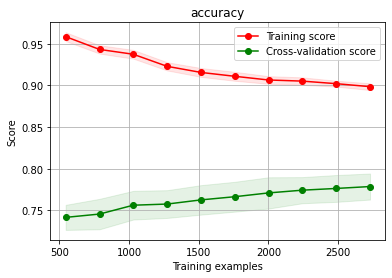

 20%|██        | 1/5 [00:42<02:49, 42.30s/it]

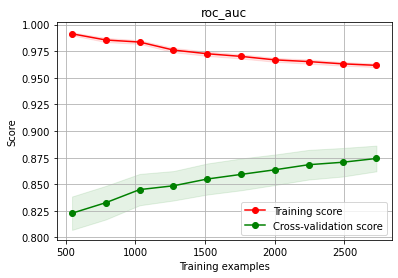

 40%|████      | 2/5 [01:27<02:11, 43.84s/it]

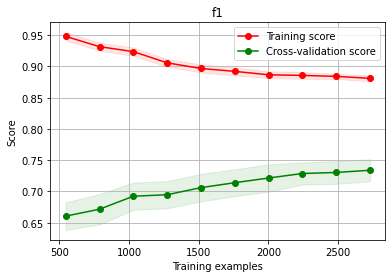

 60%|██████    | 3/5 [02:15<01:31, 45.70s/it]

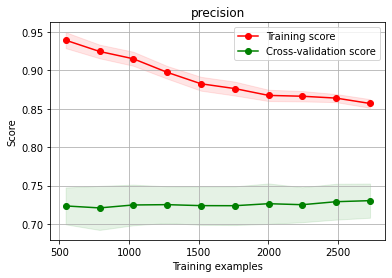

 80%|████████  | 4/5 [02:59<00:45, 45.22s/it]

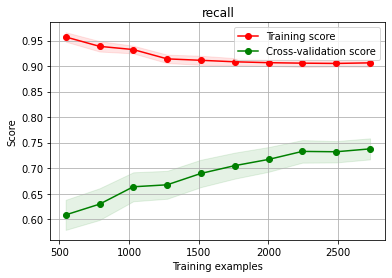

100%|██████████| 5/5 [03:45<00:00, 45.10s/it]


In [17]:
from tqdm import tqdm


for s in tqdm(['accuracy', 'roc_auc', 'f1', 'precision', 'recall']):
    plot = plot_learning_curve(
        pipeline,
        s,
        train,
        train['is_redirect'],
        scoring=s,
        cv=STRONG_CV,
        n_jobs=N_JOBS_CV,
    )
    plot.show()


In [18]:
pipeline.fit(train, train['is_redirect'])
pred = pipeline.predict(train)

In [19]:
from sklearn.metrics import roc_auc_score, f1_score
f1_score(train['is_redirect'][train['is_redirect'] == 1], np.array(pred)[train['is_redirect'] == 1])

0.9513553657630895

In [20]:
roc_auc_score(train['is_redirect'], pred)

0.8971118980169972

In [21]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
for s in [roc_auc_score, f1_score, accuracy_score]:
    print(s(pred, train['is_redirect']))

0.8906333871504283
0.8776978417266188
0.895369284876905


In [22]:
MODEL_PATH = './models/tfidf_baseline1'
save_pipeline(pipeline, MODEL_PATH)

In [23]:
MODEL_PATH = './models/tfidf_baseline1'
pipeline = load_pipeline(MODEL_PATH)
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('query_feats',
                                                 Pipeline(steps=[('query',
                                                                  ColumnSelector(col='query')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  max_features=1000,
                                                                                  ngram_range=(2,
                                                                                               3)))])),
                                                ('category_name',
                                                 Pipeline(steps=[('category_name',
                                                                  ColumnSelector(col='category_name')),
   

In [24]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
for s in [roc_auc_score, f1_score, accuracy_score]:
    print(s(pred, train['is_redirect']))

0.8906333871504283
0.8776978417266188
0.895369284876905
